# Machine learning in bioinformatics

In this chapter we'll begin talking about machine learning algorithms. Machine learning algorithms are used in bioinformatics for tasks where the user would like an algorithm to assist in the identification of patterns in a complex dataset. As is typically the case in this book, we'll work through implementing a few algorithms but these are not the implementations that you should use in practice. The code is written to be accessible for learning. [scikit-learn](http://scikit-learn.org/) is a popular and well-documented Python library for machine learning which many bioinformatics researchers and software developers use in their work. If you'd like to start trying some of these tools out, scikit-learn is a great place to start. 

```{warning}
Machine learning algorithms can easily be misused, either intentionally or unintentionally, to provide misleading results. This chapter will cover some guidelines for how to use these techniques, but it is only intended as a primer to introduce machine learning. It's not a detailed discussion of how machine learning algorithms should and shouldn't be used. If you want to start applying machine learning tools in your own research, I recommend moving from this chapter to the scikit-learn documentation, and their content on [Common pitfalls and recommended practices](https://scikit-learn.org/stable/common_pitfalls.html).
```

## The feature table

Machine learning algorithms generally are provided with a table of **samples** and user-defined **features** of those samples. These data are typically represented in a matrix, where samples are the rows and features are the columns. This matrix is referred to as a **feature table**, and it is central to machine learning and many subfields of bioinformatics. The terms used here are purposefully general. Samples are intended to be any unit of study, and features are attributes of those samples. Sometimes **labels** or **response variables** will also be associated with the samples, in which case a different class of methods can be applied. 

scikit-learn provides a few example datasets that can be used for learning. Let's start by taking a look and one of them to get an idea of what input might look like in a machine learning task.

### The Iris dataset

The [Iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset) is a classic example used in machine learning, originally published by RA Fisher {cite}`Fisher1936-tk`. This feature table describes four features of 150 specimens of Iris, a genus of flowering plant, representing three species. The feature table follows:

In [1]:
# This cell loads data from scikit-learn and organizes it into some strcutures that
# we'll use to conviently view the data.

import sklearn.datasets
import pandas as pd

iris_dataset = sklearn.datasets.load_iris(as_frame=True)
iris_feature_table = iris_dataset.frame.drop('target', axis=1)
iris_feature_table.index.name = 'sample-id'
# map target integers onto species names
iris_labels = pd.Series(iris_dataset.target_names[iris_dataset.target], 
                        index=iris_dataset.target.index, name='species').to_frame()
iris_labels.index.name = 'sample-id'

In [2]:
iris_feature_table

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sample-id,,,,
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0


The rows in this table represent our samples - in this case specimens of Iris. The columns represent features, or attributes of the samples. Each **sample vector** (i.e., row) will include a unique identifier for the sample which we usually call the _sample id_ (here these are simply integers), and values for each feature for that sample. Each **feature vector** (i.e., column) will similarly contain an identifier for the feature, or the the _feature id_. These are often simplistic descriptions of the features, as they are in this example, but they don't need to be (integers would work fine as feature ids). The feature vector then contains the values measured for that feature in each sample.

This feature table on its own can serve as an input dataset for unsupervised learning tasks, which we'll cover first in this chapter. A goal of unsupervised learning might be to determine if there are groups of samples that are most similar to one another. 

In addition to this feature table, the Iris dataset contains labels for each of the 150 samples indicating which species each sample belongs to:

In [3]:
iris_labels

,species
sample-id,
0,setosa
1,setosa
2,setosa
3,setosa
4,setosa
...,...
145,virginica
146,virginica
147,virginica


The sample ids in this label vector must be the same as the sample ids in the feature table. The feature table and the sample labels together can be used as input data for supervised learning tasks, which we'll cover second in this chapter. A goal of supervised learning might be to develop a classifier that could report the species of an Iris if provided with values for its sepal length and width and its petal length and width (i.e., the features that the algorithm originally had access).

There are three different labels, or classes, in this dataset:

In [4]:
iris_labels['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

## Unsupervised versus supervised learning methods

Many machine learning methods are classified at a high level as either unsupervised or supervised learning methods. 

In **unsupervised learning** we either don't have or don't use sample labels, and the algorithm therefore operates on a feature table alone. Typically the user is hoping to discover some structure in the data that can help them to understand which samples are most similar to each other based on their feature values. In this chapter we'll introduce ordination as an unsupervised learning task. Ordination is very widely used in biology - you may have already encountered ordination plots (such as PCoA or NMDS plots) in some of your own work. 

In **supervised learning**, on the other hand, sample labels are used in addition to a feature table. The sample labels can be discrete, as in the Iris dataset, or continuous, and that distinction defines whether we're working on a classification or regression task, respectively. The goal of a supervised learning task is typically to have the computer develop a model that can accurate predict an unlabeled sample's label from its feature values (for example, what species does an Iris specimen belong to, based on its sepal and petal length and width).

## Machine learning methods applied to microbial sequence data

In [5]:
# This cell performs some configuration for this notebook. It's hidden by
# default because it's not relevant to the content of this chapter. You'll
# occasionally notice that I hide this type of information so it's not 
# distracting.

%pylab inline

import pandas as pd
import skbio
import numpy as np
import itertools
import collections
import random

Populating the interactive namespace from numpy and matplotlib


In this chapter, we'll work with 16S rRNA data [as we did previously](load-qdr). Specifically, we'll load sequences from the Greengenes database and construct a feature table from them. We'll use this feature table in an unsupervised learning task and a supervised learning task. We'll also load labels for the sequences which we'll primarily use in our supervised learning task, but which we'll also use to aid in interpretation in our unsupervised learning task. 

Our goal with these tasks will be to explore phylum-level taxonomy of a few microbial phyla based on sequence data. In our unsupervised learning task, we'll determine if samples (i.e., sequences) coming from the same phyla appear to generally be more similar to each other than samples coming from different phyla. In our supervised learning task, we'll determine if we can develop a classifier to predict microbial phylum from an unlabeled sequence. 

Let's start by loading five sequences from each of five specific microbial phyla from Greengenes.

In [6]:
import qiime_default_reference as qdr
import skbio

def load_taxonomy_reference_database(phyla_of_interest, class_size=None, verbose=True):
    # Load the taxonomic data
    result = {}
    
    phylum_to_seq_ids = {p: set() for p in phyla_of_interest}        
    
    for e in open(qdr.get_reference_taxonomy()):
        seq_id, seq_tax = e.strip().split('\t')
        seq_tax = [e.strip() for e in seq_tax.split(';')]
        seq_phylum = ';'.join(seq_tax[:2])
            
        try:
            phylum_to_seq_ids[seq_phylum].add(seq_id)
            result[seq_id] = [seq_phylum]
        except KeyError:
            # if seq_phylum is not in phylum_to_seq_ids (i.e., it
            # wasn't provided as a phylum of interest) skip this 
            # record
            pass
        
    if verbose:
        for phylum, seq_ids in phylum_to_seq_ids.items():
            print("%d sequences were identified for phylum %s." % (len(seq_ids), phylum))

    for e in skbio.io.read(qdr.get_reference_sequences(), format='fasta', 
                           constructor=skbio.DNA):
        seq_id = e.metadata['id']
        
        if seq_id in result:
            if e.has_degenerates():
                phylum = result[seq_id][0]
                phylum_to_seq_ids[phylum].remove(seq_id)
                # for the purpose of this exercise we'll skip records 
                # that have non-ACGT characters
                del result[seq_id]
            else: 
                result[seq_id].append(e)
        else:
            # if this seq_id wasn't previously identified as being from one of our
            # phyla of interest, skip this record
            pass
    
    if class_size is not None:
        sampled_result = {}
        for p, seq_ids in phylum_to_seq_ids.items():
            if class_size > len(seq_ids):
                raise ValueError("Class size (%d) too large for phylum %s, which has only %d non-degenerate sequences." % 
                                 (class_size, p, len(seq_ids)))
            sampled_seq_ids = random.sample(seq_ids, k=class_size)
            sampled_result.update({seq_id: result[seq_id] for seq_id in sampled_seq_ids})
        result = sampled_result

    return result

(ml:define-sequences-per-phylum)=

In [7]:
phyla = {'k__Archaea;p__Crenarchaeota', 
         'k__Archaea;p__Euryarchaeota',
         'k__Bacteria;p__Cyanobacteria', 
         'k__Bacteria;p__Bacteroidetes', 
         'k__Bacteria;p__Actinobacteria'}
sequences_per_phylum = 5

seq_data = load_taxonomy_reference_database(phyla, sequences_per_phylum)

1518 sequences were identified for phylum k__Archaea;p__Euryarchaeota.
833 sequences were identified for phylum k__Archaea;p__Crenarchaeota.
2118 sequences were identified for phylum k__Bacteria;p__Cyanobacteria.
12958 sequences were identified for phylum k__Bacteria;p__Bacteroidetes.
5565 sequences were identified for phylum k__Bacteria;p__Actinobacteria.


We can look at a few randomly selected records from the data that was just compiled as follows. For each, we have a unique identifier, the source phylum for the sequence record, and a 16S rRNA sequence.

In [8]:
for seq_id in random.sample(seq_data.keys(), 3):
    print(seq_id)
    print(seq_data[seq_id][0])
    print(seq_data[seq_id][1])
    print('🦠')

137640
k__Archaea;p__Euryarchaeota
GCCGGAGATTACCGCTATCAGGATTCGATTTAGACATGCGAGGTGAATGCAGGCTTGTCCTGCATACCGAACGGCTCAGTAACACGTAGTTAATCTGGCCTCAGGTCGGGAATAACCCCGGGAAACTGGGATTAATGTCCGATAGGTTTTTGATACTGGAAGGTTCTTAAATCCAAAGCTCCGGCGCCTGAGGATGAGACTGCGGTGGATTAGGCTGTTGTTGGTGTAATGGACCAACAAACCTATAATCCATACGGGCGTTGAGAGACGTAGCCCGGAGATGTGTTCTGAGACACGAATACAGGCCCTACGGGGCGCAGCAGTTACGAAACCTTTACAATGCCTTCACGGGCGATAGGGGAATCCTGAGTGCTCTAGCAATGCTAGAGCTTTTATCTACTCCAAAAGGGTAGATGAATAAGCAGTGGGCAAGACGGGTGCCAGCCGCCACGGTAATACCCGCACTGCAAGTGGTGATCGCGTTTATTGGGTCTAAAGCGTTCGTAGCCGGTTTGGTAAATTTTTGGTGAAATCCTGTGTAAAACACAGGGCGTGCCAAAAACACTACCAGACTAGGGACCGGGAAAAGCTGAAGGTACTTTAGGGGTAGGGGCTAAATCCTGTAATCCTTGAAGGACCACCTGTGGCGAAAGCGTTCAGCTGGAACGGCTCCGACGGTGAGGGACGAAAGCCTGGGGAGCGAACGGGATTAGATACCCCGGTAGTCCAGGCCGTAAACGATGCCCGTTTGGTGTATCGTCTCCTTCGGGGAGGCGATGTGCCGTAGCGTAGGTGTTAAGCGGGCCACCTGGGGAGTACGGTCGCAAGACTTAAACTTAAGGGAATTGGCGGGGGAGCACCTCAAGGGGTGGAGGCTGCGGTTTAATTGGATTCAACGCCAGACATCTCACCAGAGAAGACAGCACTTTGACGGTCACCCTGAGGGGGTTACCTGAGGAGCTGAG

The first thing we need to generate from these data is our feature table, which raises the question of which features we want our machine learning algorithms to work with. In the last chapter, we discussed k-mers are length-k stretches of adjacent characters in a sequence. Those k-mers helped us to identify relevant sequences in our database searching, so they may be useful here as well. Let's set $k=7$, and use k-mers as the features that will define our sequence records for the examples in this chapter. The features could be anything however - if you have ideas about other values that you could compute from these sequences, come back here and try it out after you've finished reading this chapter.

(ml:define-k)=

In [9]:
k = 7

In [10]:
kmer_frequencies = {seq_id : data[1].kmer_frequencies(k=k) for seq_id, data in seq_data.items()}
sequence_feature_table = pd.DataFrame(kmer_frequencies).fillna(0).astype(int).T
sequence_feature_table.index.name = 'id'

After extracting all k-mers from the sequences and putting them in a table where the rows are our sequences (indexed by the unique sequence identifiers), the columns represent unique k-mers (labeled by the k-mer itself), and the values are the number of times each k-mer is observed in each sequence, we end up with our feature table for unsupervised and supervised learning.

In [11]:
sequence_feature_table

,GCCGGAG,CCGGAGA,CGGAGAT,GGAGATT,GAGATTA,AGATTAC,GATTACC,ATTACCG,TTACCGC,TACCGCT,...,GGGATCT,GGATCTG,GATCTGG,TCTGGCG,CTGGCGA,GGCGACT,GCGACTT,CGACTTG,TGGGACG,ACGAAGT
id,,,,,,,,,,,,,,,,,,,,,
137640,1,2,2,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
104223,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150477,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
267307,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1805758,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
250424,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
772,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197837,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36629,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As mentioned above, supervised learning tasks also require labels. In this example, the labels will be the phylum that each sequence was identified in. We'll next compile our sample label vector.

In [12]:
sequence_labels = pd.Series({k:v[0] for k, v in seq_data.items()}, name='phylum').to_frame()
sequence_labels.index.name = 'id'
sequence_labels

,phylum
id,
137640,k__Archaea;p__Euryarchaeota
104223,k__Archaea;p__Euryarchaeota
150477,k__Archaea;p__Euryarchaeota
267307,k__Archaea;p__Euryarchaeota
1805758,k__Archaea;p__Euryarchaeota
250424,k__Archaea;p__Crenarchaeota
772,k__Archaea;p__Crenarchaeota
197837,k__Archaea;p__Crenarchaeota
36629,k__Archaea;p__Crenarchaeota


Our data is ready, so let's get started with unsupervised learning. 

## Unsupervised learning

We'll begin our exploration of machine learning approaches with unsupervised learning, and specifically with ordination. We'll work through ordination in two strokes. First, we'll explore an approach called **Polar Ordination**, where the math is simple but which isn't widely used in practice because more informative techniques exist. Working through this on a small data set will give you an idea of how ordination techniques can reduce the dimensionality of a data set and how to interpret the results of an ordination. Then, we'll apply an approach called **Principal Coordinates Analysis (PCoA)**. The math for PCoA is a bit more complicated than I want get into this book, but we'll look at how to apply PCoA using scikit-bio.

### Computing distances between samples

Most ordination techniques begin with computing **distances** between all pairs of samples. A simple and useful way to define distances between our samples is by computing the fraction of k-mers that are unique to either sample. This is known as the Jaccard Distance between the samples. This metric derives from set theory, and is the inverse of the Jaccard Index (or Jaccard Similarity). It is defined as follows:

```{math}
:label: jaccard_sim
Jaccard \, Index_{(A,B)} = \frac{| A \cap B |}{| A \cup B |}
```

Let's break this formula down. First, $(A,B)$ defines the two samples we're computing distances between. We refer to them here with the variables $A$ and $B$. $| A \cap B |$ is the count of features that are observed, or that have a value of one or more, in both samples. If you've studied set theory, you may recognize this as the size of the intersection of the sets of k-mers in samples $A$ and $B$. That number is divided by $| A \cup B |$, which is the count of features that are observed in either or both of the samples. In set theory terminology, this is the size of the union of the sets of k-mers in samples $A$ and $B$. The resulting value is a measure of the similarity of the two samples. To make this a distance, we simply subtract that value from 1. 

```{math}
:label: jaccard_dist
Jaccard \, Distance_{(A,B)} = 1 - Jaccard \, Index_{(A,B)}
```

If we apply this computation to all pairs of samples in our feature table, we can store the results in a **distance matrix**. This can be computed from our feature table as follows using scikit-bio.

In [13]:
import skbio.diversity

sequence_distance_matrix = skbio.diversity.beta_diversity('jaccard', sequence_feature_table, ids=sequence_feature_table.index)

/usr/share/miniconda/envs/q2book/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1761: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


A convenient way to get an initial glance at patterns in a small dataset like the one we're working with here would be to plot the distance matrix as a heatmap. Here, colors represent the distances and larger distances imply that a pair of samples are dissimilar from each other in their kmer content. 

Notice that the values along the diagonal are zero: this is because the diagonal represents distances between a sequence and itself, which is always zero. In other words, $Jaccard \, Distance_{(A,A)} = 0$. Also notice that the matrix is symmetric, meaning that if you were to flip the values across the diagonal they would be equal to each other. In other words, $Jaccard \, Distance_{(A,B)} = Jaccard \, Distance_{(B,A)}$.

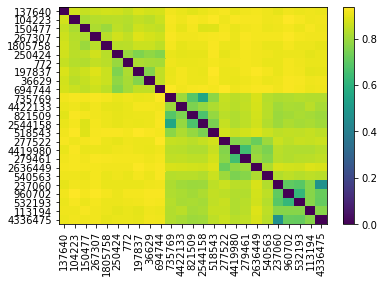

In [14]:
sequence_distance_matrix

```{admonition} Exercise
If you refer back to the table of our sample labels (defined in the `sequence_labels` variable) above, do you notice any patterns emerging from this heatmap?
```

If you want to look up the distance between a specific pair of samples, you can do that as follows:

In [15]:
sample_id1 = sequence_feature_table.index[0]
sample_id2 = sequence_feature_table.index[1]
d = sequence_distance_matrix[sample_id1, sample_id2]
print('The Jaccard Distance between samples %s and %s is %1.3f.' % (sample_id1, sample_id2, d))

The Jaccard Distance between samples 137640 and 104223 is 0.872.


### Polar ordination

Now that we have distances between all pairs of samples, we can perform a polar ordination on the samples. Results of ordination are typically viewed in a scatterplot with two or three dimensions, so I find it useful to think through polar ordination as an approach to build a scatterplot from this distance matrix. 

First, identify the largest distance in the distance matrix and note the sample ids associated with that distance. We'll refer to this distance as $D$.

In [16]:
sorted_indices = np.argsort(sequence_distance_matrix.data, axis=None)[::-1]
sorted_indices = np.unravel_index(sorted_indices, shape=sequence_distance_matrix.shape)
sample_id1 = sequence_distance_matrix.ids[sorted_indices[0][0]]
sample_id2 = sequence_distance_matrix.ids[sorted_indices[0][1]]
D = sequence_distance_matrix[sample_id1, sample_id2]
print('The largest distance in the distance matrix is %1.3f, between samples %s and %s.' % 
    (D, sample_id1, sample_id2))

The largest distance in the distance matrix is 0.937, between samples 518543 and 197837.


These two samples define the first axis of your scatter plot. The length of this axis is $D$, and each sample will be placed at an endpoint on this axis. Choose one sample to be plotted at zero on this axis, and the other sample to plot at $D$ on this axis. It doesn't matter which sample you choose to plot at which endpoint. 

Next, we'll identify the location of every other samples on this first axis. For each sample $s$, this computed with the following formula.

```{math}
:label: polar-ordination-axis
A_s = \frac{D^2 + D1^2 - D2^2}{2 \times D}
```

In this formula, $A_s$ is the location of the current sample on the current axis. $D$ is distance between the endpoints. $D1$ is distance between the current sample and the sample at $0$ on this axis, which you can look up in the distance matrix computed above. $D1$ is distance between the current sample and the sample at $D$ on this axis, which is also looked up in the distance matrix. 

The following Python function can be applied to compute the placement of all samples on a polar ordination axis, given the distances between all pairs of samples and the identifiers of the samples serving as the endpoints of this axis.

In [17]:
def compute_axis(dm, endpoint1, endpoint2):
    d = dm[endpoint1, endpoint2]
    result = {endpoint1: 0, endpoint2: d}
    non_endpoints = set(dm.ids) - set([endpoint1, endpoint2])
    for e in non_endpoints:
        d1 = dm[endpoint1, e]
        d2 = dm[endpoint2, e]
        result[e] = (d**2 + d1**2 - d2**2) / (2 * d)
    return pd.Series(result)

In [18]:
axis1_values = compute_axis(sequence_distance_matrix, 
                            sample_id1,
                            sample_id2)

At this stage, we have computed our first polar ordination axis. If we sort and view this axis we may even be able to see some clustering or grouping of samples along this axis.

In [19]:
axis1_values.sort_values()

518543     0.000000
2544158    0.329721
735769     0.349748
821509     0.359022
4422133    0.378162
960702     0.402577
532193     0.405159
237060     0.411062
4336475    0.414479
540563     0.415617
4419980    0.416755
279461     0.421509
2636449    0.425402
113194     0.429906
277522     0.434348
150477     0.493070
267307     0.499807
137640     0.500351
1805758    0.531332
694744     0.538884
104223     0.543300
772        0.561741
36629      0.617013
250424     0.622539
197837     0.936975
dtype: float64

```{admonition} Exercise
If you again refer back to the table of our sample labels (defined in the `sequence_labels` variable) above, do you notice any patterns in the ordered samples along this axis?
```

We can plot this single axis using a strip plot. In this plot, only placement on the horizontal axis is meaningful. The variation in placement of points along the vertical axis is only to aid in visualization. In this plot, each point represents a single sample from our feature table. Samples that are closer in space along this axis are more similar to each other in their k-mer composition.

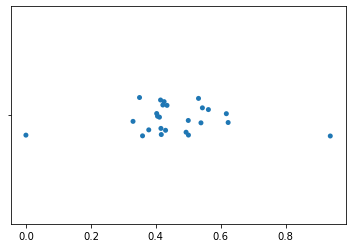

In [20]:
import seaborn as sns

sns.stripplot(x=axis1_values)

While we may already be able to see some clustering of samples on the first axis, additional axes that are uncorrelated with this first axis can provide more information about which samples are most similar to each other. 

Selecting the next axis to plot in polar ordination can be a little tricky however. Generally, you would begin by computing all axes, which would be defined for all pairs of samples, and then selecting the axes that represent the largest distances (as we did for our first axis above), and axes that are uncorrelated with previously selected axes. This Python function will compute all polar ordination axes.

In [21]:
def polar_ordination(dm):
    result = []
    axis_labels = []
    for i, id1 in enumerate(dm.ids):
        for id2 in dm.ids[:i]:
            axis_label = '%s to %s' % (id1, id2)
            axis_labels.append(axis_label)
            result.append(compute_axis(dm, id1, id2) )
    result = pd.concat(result)
    result.set_index(axis_labels)
    return result

We can apply this function to our distance matrix, and see all of the polar ordination axes.

In [22]:
sequence_polar_ordination = polar_ordination(sequence_distance_matrix)
sequence_polar_ordination

AttributeError: 'Series' object has no attribute 'set_index'

This isn't much (or any) more interpretable than the distance matrix itself was, so the next step is to select the most informative axes to view. The first (most informative) axis will be the axis that we identified above as the one representing the largest distance in the distance matrix. The second will be an axis that also contains a large distance (relative to the other distances in the distance matrix), and is uncorrelated with the first axis. Selecting this axis based on these criteria is a bit subjective, so we need to come up with an objective approach so a computer can solve the problem. Here, I define an algorithm that will create a _score_ for each axis that is computed as the largest distance along that axis divided by the absolute value of the Spearman correlation coefficient between this axis and axis 1. In other words:

```{math}
:label: polar_ordination_axis_score
Score_{axis i} = \frac{axis length}/{|Spearman(Axis 1, Axis 1)|}
```

This can be computed as follows:

In [ ]:
def select_polar_ordination_axes(polar_ordination_result):
    # this function would be better if it defined more axes, 
    # eg by always looking for correlation with preceding axis. 
    distance_sorted_ord_axes = sequence_polar_ordination.max().sort_values(ascending=False)
    first_axis_idx = distance_sorted_ord_axes.index[0]
    corrs = sequence_polar_ordination.corrwith(sequence_polar_ordination[first_axis_idx], method='spearman').abs().sort_values(ascending=False)
    scores = distance_sorted_ord_axes / corrs
    result = pd.concat([distance_sorted_ord_axes, corrs, scores], axis=1)
    result.columns = ['maximum distance', 'corr with first axis', 'score']
    result.sort_values(by='score', ascending=False, inplace=True)
    second_axis_idx = result.index[0]
    return first_axis_idx, second_axis_idx, result

In [ ]:
first_axis_idx, second_axis_idx, axis_summaries = select_polar_ordination_axes(sequence_polar_ordination)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

_ = sns.scatterplot(x=sequence_polar_ordination[first_axis_idx], 
                    y=sequence_polar_ordination[second_axis_idx])

Add metadata

In [ ]:
_ = sns.scatterplot(x=sequence_polar_ordination[first_axis_idx], 
                    y=sequence_polar_ordination[second_axis_idx], 
                    hue=sequence_labels['phylum'])
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
axis_summaries

Why do we care about axes being uncorrelated?

In [ ]:
# the axis most correlated with first_axis_idx will be first_axis_idx, so 
# select the second axis
correlated_axis_idx = axis_summaries.sort_values(by='corr with first axis', ascending=False).index[1]

In [ ]:
_ = sns.scatterplot(x=sequence_polar_ordination[first_axis_idx], 
                    y=sequence_polar_ordination[correlated_axis_idx], 
                    hue=sequence_labels['phylum'])
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

 And why do we care about starting with large distances?

In [ ]:
small_distance_axis_idx = axis_summaries.sort_values(by='maximum distance', ascending=True).index[0]

In [ ]:
_ = sns.scatterplot(x=sequence_polar_ordination[first_axis_idx], 
                    y=sequence_polar_ordination[small_distance_axis_idx], 
                    hue=sequence_labels['phylum'])
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Interpreting ordination plots <link src='40e0a6'/>

There are a few points that are important to keep in mind when interpreting ordination plots. Review each one of these in the context of polar ordination to figure out the reason for each.

**Directionality of the axes is not important (e.g., up/down/left/right)**

One thing that you may have notices as you computed the polar ordination above is that the method is *not symmetric*: in other words, the axis values for axis $EB$ are different than for axis $BE$. In practice though, we derive the same conclusions regardless of how we compute that axis: in this example, that samples cluster by body site.

In [ ]:
import skbio.stats.ordination


sequence_pcoa_ordination = skbio.stats.ordination.pcoa(sequence_distance_matrix)

_ = sns.scatterplot(x=sequence_pcoa_ordination.samples['PC1'], 
                    y=sequence_pcoa_ordination.samples['PC2'])

In [ ]:
_ = sns.scatterplot(x=sequence_pcoa_ordination.samples['PC1'], 
                    y=sequence_pcoa_ordination.samples['PC2'], 
                    hue=sequence_labels['phylum'])
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Some other important features:

* Numerical scale of the axis is generally not useful
* The order of axes is generally important (first axis explains the most variation, second axis explains the second most variation, )
* Most techniques result in uncorrelated axes.
* Additional axes can be generated (third, fourth, )

### Principle Coordinates Analysis (PCoA)

```
import qiime2
import qiime2.plugins.feature_table as ft
import qiime2.plugins.diversity as div

# Iterate over all of the reference sequences and compute their kmer frequencies.
per_sequence_kmer_counts = []
for reference_sequence in reference_db:
    #taxon = get_taxon_at_level(reference_sequence.metadata['taxonomy'], taxonomic_level)
    kmer_counts = dict.fromkeys(W, 0)
    kmer_counts.update(reference_sequence.kmer_frequencies(k=k))
    per_sequence_kmer_counts.append(pd.Series(kmer_counts, name=reference_sequence.metadata['id']))

# Build a table of the kmer frequencies as a pandas.DataFrame object, and then 
# display the first 25 rows of that table.
per_sequence_kmer_counts = pd.DataFrame(data=per_sequence_kmer_counts).fillna(0).T

feature_table_1a = qiime2.Artifact.import_data("FeatureTable[Frequency]", per_sequence_kmer_counts.T)
```

```
jaccard_1a = div.actions.beta(feature_table_1a, metric='jaccard').distance_matrix
```

```
taxa_of_interest = ['k__Archaea', 'p__Cyanobacteria', 'p__Firmicutes', 'p__Bacteroidetes', 'p__Proteobacteria']
metadata = {}
for reference_sequence in reference_db:
    id_ = reference_sequence.metadata['id']
    taxon = get_taxon_at_level(reference_sequence.metadata['taxonomy'], taxonomic_level)
    label_as_other = True
    for taxon_of_interest in taxa_of_interest:
        # this approach is horrendous
        if taxon_of_interest in taxon:
            label_as_other = False
    if label_as_other:
        metadata[id_] = 'Other'
    else:
        metadata[id_] = taxon
metadata = pd.Series(metadata, name='taxon').to_frame()
metadata.index.name = 'id'
metadata = qiime2.Metadata(metadata)
```

```
pcoa_1a = div.actions.pcoa(jaccard_1a).pcoa
```

```
import qiime2.plugins.emperor as emperor

emperor.actions.plot(pcoa_1a, metadata).visualization
```

```
import skbio.stats.ordination
ordination = pcoa_1a.view(skbio.stats.ordination.OrdinationResults)

_ = ordination.plot(metadata.to_dataframe(), column='taxon', cmap='Set1')
```

## Supervised classification

We'll continue our exploration of machine learning approaches with **supervised classification**, and specifically with an algorithm called **Naive Bayes**.  We'll implement Naive Bayes to gain an understanding of how it works, and I think you'll discover that this idea of machines learning isn't quite as mysterious or science fiction-y as it sounds. The math involved in Naive Bayes is relatively straight-forward, which is why I chose this algorithm to present here. There are many machine algorithms with more complex math, but Naive Bayes is  widely used and powerful, so it's a good place to get started. 

We'll explore supervised classification in the context of a now familiar topic: taxonomic classification of 16S rRNA sequences. We previously explored this problem in {doc}`database-searching`, so it's worth spending a few minutes skimming that chapter if it's not fresh in your mind.

Briefly, the problem that we are going to address here is as follows. We have a query sequence ($q_i$) which is not taxonomically annotated (meaning we don't know the taxonomy of the organism whose genome it is found in), and a reference database ($R$) of taxonomically annotated sequences ($r_1, r_2, r_3, r_n$). We want to infer a taxonomic annotation for $q_i$. We'll again work with [Greengenes](http://greengenes.secondgenome.com/), a 16S rRNA sequence database, which we'll access using [QIIME default reference project](https://github.com/biocore/qiime-default-reference). (This should all sound very familiar - if not, I again suggest that you review {doc}`database-searching`.)

Before we get to this though, lets talk about what supervised classification algorithms are and how the classifiers they build are evaluated. 

### Defining a classification task

In a classification task, there are two or more pre-defined classes, and the goal is to assign observations to those classes. As humans, we run perform these kinds of tasks everyday. For example, if you're browsing a bookstore you might classify titles as ones you want to read versus everything else (the ones you're not interested in reading). You might group the apps that you have on your phone into folders by classifying them by category (e.g., "school", "entertainment", or "social media"). 

When we're working with large data sets, supervised classification algorithms can help us with classification tasks that will make us more efficient or help us understand our data. A classic example of this outside of bioinformatics is an email spam filter. For every email that is received, the spam filter must define it as spam or not spam so the message can directed either to the user's spam folder or the user's inbox. The stakes can be high: a filter that is too permissive will cause the user's inbox to get filled with junk mail, while a filter that is overly restrictive could cause relevant messages to be directed to the spam folder. In either case, the email user could miss important messages.

In the case of taxonomic assignment, our classes will be taxonomic groups at a user-defined taxonomic level. For example, a phylum classifier for 16S rRNA sequences would take an unannotated sequence as input and as output present the phylum that the sequence most likely originated from.

### Training data, test data, and cross-validation

Supervised classification algorithms need to be provided with data that is used to develop a model to use in classification (in other words, to train the classifier). This data is a collection of observations with defined classes, and is referred to as the **training data**. These labeled examples are the "supervision" aspect of supervised learning. In the email spam filter example, this would be email messages that are annotated as either spam or not spam. In the 16S taxonomy assignment example, this would be 16S sequences that are taxonomically annotated. It is typically important that the training data be balanced - in other words, that there are roughly the same number of examples of each class.

In addition to the training data, an independent collection of observations with defined classes is needed as **test data**. These observations are not used to train the classifier, but rather to evaluate how the classifier performs on previously unseen data. The goal of testing the classifier on these test data is to predict what performance will be on **real world** data. Real world data refers to data for which the class is currently unknown. In the spam filter example, real world data would be new emails that you are receiving. In the 16S rRNA taxonomy assignment example, real world data could be sequences that you obtain from the environment using a DNA sequencing instrument. The test data shouldn't be used for optimization of classifiers: in other words, you shouldn't develop a classifier on training data, test it on test data, go back and make changes to the classifier, and then re-test on test data. This would risk **over-fitting** the classifier to a particular test data set and performance on that test data may no longer be predictive of how the classifier will perform when it is used on real world data. 

Because training and test data sets can be very costly to develop (for example, they may require many hours of annotation by humans) we often use an approach call **k-fold cross validation** during classifier development and optimization {numref}`cross-validation-1`. In k-fold cross-validation, the training data is split into `k` different data sets, where `k` is usually five or ten. In each of the data sets, $1/k$ of the entries are used as test data and all of the other entries are used as training data. In `k` iterations, the classifier is developed on the training data and tested on the test data. The average performance of the classifier is then computed across the `k` iterations. k-fold cross validation therefore allows for developing and optimizing a classifier without using dedicated test data.

```{figure} ./images/ml-cross-validation.png
---
name: cross-validation-1
---
An illustration of k-fold cross validation where a single data set is split into k independent training and test data sets. Each circle represents a labeled entry for use in training or testing, and colors indicate the class of each entry. In the case of a spam filter, for example, red circles might represent spam messages while green circles represent messages that are not spam.
Image source: [Gufosowa](https://commons.wikimedia.org/wiki/File:K-fold_cross_validation_EN.svg), [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0), via Wikimedia Commons.
```

### Evaluating a binary classifier 

As mentioned above, in a classification task there are two or more pre-defined classes. A binary classifier would be a specific type of classifier for which there are exactly two classes - for example, spam and not spam. We'll start talking about how classifiers are evaluated by discussing binary classifiers because they're the easiest to understand. 

Imagine we're building a classifier that attempts to predict whether an individual is healthy or has some specific disease (let's call it *Disease X*). Perhaps the data that the classifier uses is based on a variety of medical data that has undergone a feature extraction process to generate features that can be used by a supervised classification algorithm. When a classifier is developed, you can think of it like a function that will take a collection of features for a sample and return a value of "healthy" or "diseased". 

The goal of our classifier is to serve as a diagnostic tool that identifies whether a patient has Disease X based on features of their medical data. A positive test result therefore indicates that the patient has Disease X while a negative test result indicates that they are healthy. When we apply our classifier to test data (i.e., where we know the correct class), there are a few possible outcomes. 

* The classifier predicts a positive test result, and the sample is known to come from a patient with Disease X. This is a **true positive (TP)**. 
* The classifier predicts a positive test result, and the sample is known to come from a healthy patient. This is a **false positive (FP)**. FPs are also referred to as type 1 errors.
** The classifier predicts a negative test result, and the sample is known to come from a patient with Disease X. This is a **false negative (FN)**. FNs are also referred to as type 2 errors.
* The classifier predicts a negative test result, and the sample is known to come from a healthy patient. This is a **true negative (TN)**. 

A classifier would typically be evaluated by running it on many samples and tallying the count of TP, FP, FN, and TN results. These tallies are typically presented in a structure known as a **confusion matrix**. For the confusion matrix, there many different values that can be computed which inform us of some aspect of classifier performance. 

The simplest way to think about evaluating the performance of our classifier from a confusion matrix is to compute its **accuracy** as:

```{math}
:label: accuracy
accuracy = \frac{TP + TN}{TP + FP + FN + TN}
```

In words, accuracy can be defined as the fraction of the total test cases that the classifier classified correctly. Accuracy gives us an idea of the classifier performance, but it hides some potentially relevant information from us. A low accuracy classifier could, for example, almost never achieve false positives but frequently achieve false negatives. Such a classifier could still be a clinically useful tool. Because false positives are very infrequent but false negatives are common, that means when the classifier indicates a positive test result that person nearly always has the disease. If the classifier indicates a negative result, that could be an indicator that additional testing is needed. Of course we would rather our classifier achieve fewer false negatives, but if this is a very cheap test and the additional tests are more expensive, it could be a useful first screening approach. 

Two other metrics are more widely used for evaluating classifiers, and these are typically computed as a pair. These metrics are **precision** and **recall** and they are more informative than accuracy because they indicate whether a classifier might suffer more from false positives or false negatives. 

Precision is the fraction of the positives reported by the classifier that are actually positives, or:

```{math}
:label: precision
precision = \frac{TP}{TP + FP}
```

Recall is the fraction of the actual positives that are reported to be positive by the classifier, or:

```{math}
:label: recall
recall = \frac{TP}{TP + FN}
```

Precision thus tells us how frequently our classifier yields false positives, while recall tells us how frequently our classifier yields false negatives. We of course would always like both of these values to be high, but depending on the application of our classifier, we may prefer high precision over high recall, or we may prefer high recall over high precision. 

### Naive Bayes classifiers

Naive Bayes classifiers work by building a model of what different classes look like based on labeled training data. In the case of taxonomic assignment of 16S sequences, the classes are different microbial taxonomy names at a given taxonomic level. For example, Proteobacteria and Cyanobacteria would be two classes if we were building a classifier for bacterial phyla. The data that is provided would be the 16S sequences associated with different representatives of the classes, but more specifically Naive Bayes needs these sequences broken into finer-grained features for it to work well. The development of features from raw training data is referred to as **feature extraction**. This can be part of the classifier training software, or it can be independent. Features of sequences could be nearly anything, such as sequence length, presence or absence of certain sequence patterns (or motifs), GC content, and so on. The most commonly used features for sequence classification tasks such as this is {ref}`overlapping kmers <kmer>`, which we have previously seen when looking at heuristic algorithms for database searching. In this case, feature extraction for a given sequence would involve the identification of all of the kmers contained in that sequence.

In this chapter, instead of using sequence alignment to identify the most likely taxonomic origin of a sequence, we'll train Naive Bayes classifiers to do this by building {ref}`kmer <kmer>`-based models of the 16S sequences of taxa in our reference database. We'll then run our query sequences through those models to identify the most likely taxonomic origin of each query sequence. Since we know the taxonomic origin of our query sequences in this case, we can evaluate the accuracy of our classifiers by seeing how often they return the known taxonomy assignment. If our training and testing approaches are well-designed, the performance on our tests will inform us of how accurate we can expect our classifier to be on data where the actual taxonomic origin is unknown. 



### Training a Native Bayes classifier 

The first thing our Naive Bayes classifier will need is the set of all possible words of length ``k``. This will be dependent on the value of ``k`` and the characters in our alphabet (i.e., the characters that we should expect to find in the reference database). This set is referred to as ``W``, and can be computed as follows.

In [ ]:
alphabet = skbio.DNA.nondegenerate_chars
k = 2

def compute_W(alphabet, k):
    return set(map(''.join, itertools.product(alphabet, repeat=k)))

W = compute_W(alphabet, k)

print('Alphabet contains the characters: %s' % ', '.join(alphabet))
print('For an alphabet size of %d, W contains %d length-%d kmers.' % (len(alphabet), len(W), k))

```{admonition} Exercise
Given the DNA alphabet (A, C, G, and T), how many different kmers of length 3 are there (i.e., 3-mers)? How many different 7-mers are there? How many 7-mers are there if there are twenty characters in our alphabet (as would be the case if we were working with protein sequences instead of DNA sequences)?
```

The next thing we'll need to train our classifier is a way to extract all kmers from a given sequence. scikit-bio provides this functionality in the ``skbio.DNA`` sequence object (as well as in the other sequence object types). It also provides functionality for computing the kmer frequencies in a given sequence. This information can be obtained for one of our reference sequences as follows:

In [ ]:
## This cell needs revision to fit in to the refactored code
# compute all kmers for the specified alphabet
W = compute_W(alphabet, k)

# Define a function that returns the taxonomy at a specified level given
# a semi-colon separated taxonomic description.
# For example, providing 'k__Bacteria; p__Gemmatimonadetes; c__Gemm-1; o__; f__; g__; s__'
# as input will return 'k__Bacteria; p__Gemmatimonadetes' as output.
def get_taxon_at_level(taxon, level):
    taxon = [l.strip() for l in taxon.split(';')]
    return '; '.join(taxon[:level])

# Iterate over all of the reference sequences and compute their kmer frequencies.
per_sequence_kmer_counts = {}
sequence_labels = {}
for reference_sequence in reference_db:
    sequence_id = reference_sequence.metadata['id']
    
    taxon = get_taxon_at_level(reference_sequence.metadata['taxonomy'], taxonomic_level)
    sequence_labels[sequence_id] = taxon
    
    kmer_counts = dict.fromkeys(W, 0)
    kmer_counts.update(reference_sequence.kmer_frequencies(k=k))
    per_sequence_kmer_counts[sequence_id] = kmer_counts

feature_table = pd.DataFrame(data=per_sequence_kmer_counts).fillna(0).T
sequence_labels = pd.Series(sequence_labels, name='taxon')

In [ ]:
kmers = reference_db[0].iter_kmers(k=k)
for kmer in kmers:
    print(kmer, end=' ')

That's a lot of kmers, and of course many of them are present multiple times. Tallies of the frequencies of each kmer can be computed as follows.

In [ ]:
print(reference_db[0].kmer_frequencies(k=k))

This information can be convenient to store in a pandas ``Series`` object:

In [ ]:
pd.Series(reference_db[0].kmer_frequencies(k=k), name=reference_db[0].metadata['id'])

To train our taxonomic classifier, we next need to define a few things. First, at what level of taxonomic specificity do we want to classify our sequences? We should expect to achieve higher accuracy at less specific taxonomic levels such as phylum or class, but these are likely to be less informative biologically than more specific levels such as genus or species. Let's start classifying at the phylum level to keep our task simple, since we're working with a small subset of the reference database here. In Greengenes, phylum is the second level of the taxonomy.

Next, how long should our kmers be? We don't have a good idea of this to start with. The longer our kmers, the more likely they are to be specific to certain taxa, which is good because that will help with classification. However, if they get too long it becomes less likely that we'll observe those kmers in sequences that aren't represented in our database because the longer the sequence is the more likely we are to see variation across other organisms that are assigned to the same taxonomy. Based on some of my own work in this area, I'll start us out with 7-mers (i.e., kmers of length 7).

Finally, we'll need to know the value of `W`, defined above as the set of all possible kmers given our alphabet and the value of `k`.



With this information, we'll next compute our kmer probability table. The content of this table will be the probability of observing every kmer in W given a taxon. This is computed based on a few values:

$N$ : The total number of sequences in the training set (i.e., our reference database).

$W$: The set of all possible kmers, given $k$ and an alphabet.

$w_i$: An individual kmer in $W$.

$n(w_i)$ : The number of total sequences containing $w_i$.

$P_i$ : The probability of observing $w_i$. Initially it might seem as though this would be computed as $n(w_i) / N$, but this neglects the possibility that a kmer observed in a query sequence might not be represented in our reference database (i.e., $n(w_i) = 0$), which would create problems later, when we're assigning probabilities to each class for query sequences. As a result, 0.5 is added to the numerator and 1 is added to the denominator. When we alter counts in this way, we refer to the values that we're adding as **pseudocounts**. 

$P(w_i | taxon)$ : The probability of observing a kmer given a taxon. Again, it would seem that this would be computed as the proportion of sequences in the taxon containing the kmer, but this would neglect that we'll likely observe kmers in our query sequences that are not represented in our reference database. A pseudocount is therefore added again to the numerator and denominator. This time the pseudocount in the numerator is scaled by how frequent the kmer is in the reference database as a whole: specifically, it is $P_i$.

Our "kmer probability table" is $P(w_i | taxon)$ computed for all kmers in W and all taxa represented in our reference database. We'll compute that and again look at the first 25 rows.

In [ ]:
def compute_kmer_probability_table(feature_table, sequence_labels):
    N = feature_table.shape[0] # number of training sequences

    # number of sequences containing kmer wi
    n_wi = feature_table.astype(bool).sum(axis=0)
    n_wi.name = 'n(w_i)'

    # probabilities of observing each kmer
    Pi = (n_wi + 0.5) / (N + 1)
    Pi.name = 'P_i'
    
    # number of times each taxon appears in training set
    taxon_counts = collections.Counter(sequence_labels)

    
    taxon_table = feature_table.astype(bool).groupby(by=sequence_labels, axis=0).sum()
    
    # probabilities of observing each kmer in each taxon
    p_wi_t = []
    for taxon, count in taxon_counts.items():
        p_wi_t.append(pd.Series((taxon_table.loc[taxon] + Pi) / (count + 1), name=taxon))

    return pd.DataFrame(p_wi_t).T

In [ ]:
kmer_probability_table = compute_kmer_probability_table(feature_table, sequence_labels)
kmer_probability_table[:25]

In [ ]:
def load_taxonomy_query_sequences(start_position=100, length=200):
    queries = []
    for e in skbio.io.read(qdr.get_reference_sequences(), format='fasta', constructor=skbio.DNA):
        if e.has_degenerates():
            # For the purpose of this lesson, we're going to ignore sequences that contain
            # degenerate characters (i.e., characters other than A, C, G, or T)
            continue
        e = e[start_position:start_position + length]
        queries.append(e)

    return queries

We'll load a collection of query sequences as we did in {doc}`database-searching`.

In [ ]:
import random

queries = load_taxonomy_query_sequences()
queries = random.sample(queries, k=50)

Again, we can index into these results to look at individual sequences. Note that because we're trying to emulate working with unannotated sequences here, the query sequences don't have taxonomic annotations in their metadata.

In [ ]:
queries[0]

For a given query sequence, its taxonomy will be classified as follows. First, the set of all kmers will be extracted from the sequence. This is referred to as $V$. Then, for all taxa in the kmer probability table, the probability of observing the query sequence will be computed given that taxon: $P(query | taxon)$. This is computed as the product of all its kmer probabilities for the given taxon. (It should be clear based on this formula why it was necessary to add pseudocounts when computing our kmer probability table - if not, kmer probabilities of zero would result in a zero probability of the sequence being derived from that taxon at this step.)

After computing $P(query | taxon)$ for all taxa, the taxonomy assignment returned is simply the one achieving the maximum probability. Here we'll classify a sequence and look at the resulting taxonomy assignment.

In [ ]:
# This function classifies a sequence that has already been split into a list
# of kmers.
def classify_V(V, kmer_probability_table):
    P_S_t = [] # probability of the sequence given the taxon
    for taxon in kmer_probability_table:
        kmer_probabilities = kmer_probability_table[taxon]
        probability = 1.0
        for v_i in V:
            probability *= kmer_probabilities[v_i]
        P_S_t.append((probability, taxon))
    return max(P_S_t)[1], V

# This function is a little more convenient to use. It classifies a sequence 
# directly, first by computing V, and then by calling classify_V.
def classify_sequence(query_sequence, kmer_probability_table, k):
    V = list(map(str, query_sequence.iter_kmers(k=k)))
    return classify_V(V, kmer_probability_table)

In [ ]:
query = queries[0]
taxon_assignment, V = classify_sequence(query, kmer_probability_table, k)
print(taxon_assignment)

Since we know the actual taxonomy assignment for this sequence, we can look that up in our reference database. Was the assignment correct?

In [ ]:
get_taxon_at_level(reference_taxonomy[query.metadata['id']], taxonomic_level)

```{admonition} Exercise
Try classifying a few other query sequences and determining if the returned class was correct. You can do this by changing which entry in `queries` you're assigning to the value `query`. Keep track of how many times the classifier returned the correct assignment.
```

### Evaluating our confidence in the results of the Naive Bayes classifier

Because the query and reference sequences that were working with were randomly selected from the full reference database, each time you run this notebook you should observe different results. Chances are however that if you run the above steps multiple times you'll get the wrong taxonomy assignment at least some of the time. Up to this point, we've left out an important piece of information: how confident should we be in our assignment, or in other words, how dependent is our taxonomy assignment on our specific query? If there were slight differences in our query (e.g., because we observed a very closely related organism, such as one of the same species but a different strain, or because we sequenced a different region of the 16S sequence) would we obtain the same taxonomy assignment? If so, we should have higher confidence in our assignment. If not, we should have lower confidence in our assignment. This is additionally important because our classifier will _always_ return one of the classes, even if our query sequence is very different than any of the sequences in our reference database.

We can quantify confidence using an approach called bootstrapping. With a bootstrap approach, we'll get our taxonomy assignment as we did above, but then for some user-specified number of times, we'll create random subsets of V sampled with replacement. We'll then assign taxonomy to each random subset of V, and count the number of times the resulting taxonomy assignment is the same as the one we received when assigning taxonomy to V. The count of times that they are the same divided by the number of iterations we've chosen to run will be our confidence value. If the assignments are often the same we'll have a high confidence value. If the assignments are often different, we'll have a low confidence value.

Let's now assign taxonomy and compute a confidence for that assignment.

In [ ]:
def classify_sequence_with_confidence(sequence, kmer_probability_table, k,
                                      confidence_iterations=100):
    # classify the query sequence, as we did above
    taxon, V = classify_sequence(sequence, kmer_probability_table, k)

    count_same_taxon = 0
    # Define the size of each subsample as 10% of the actual number of
    # kmers in the query sequence.
    subsample_size = int(len(V) * 0.1)
    # Perform n iterations (where n is provided by the user as 
    # confidence_iterations) where a random subset of the query sequence's
    # kmers are used for the classification task.
    # Keep track of the number of times the observed result is the same as
    # that for the query sequence. 
    for i in range(confidence_iterations):
        subsample_V = np.random.choice(V, subsample_size, replace=True)
        subsample_taxon, _ = classify_V(subsample_V, kmer_probability_table)
        if taxon == subsample_taxon:
            count_same_taxon += 1
    confidence = count_same_taxon / confidence_iterations

    return (taxon, confidence)

In [ ]:
taxon_assignment, confidence = classify_sequence_with_confidence(queries[0], kmer_probability_table, k)
print(taxon_assignment)
print(confidence)

How did the computed confidence compare to the accuracy taxonomy assignment?

At first glance, we don't necessarily have an idea of what good versus bad confidence scores are, but we can use our reference database to explore that. Knowing that can allows us to develop a confidence threshold that we can use in our work. For example, we can define a confidence threshold above which we would accept a taxonomy assignment and below which we might reject it. To explore this, let's compute taxonomy assignments and confidence for all of our query sequences and then see what the distributions of confidence scores look like for correct assignments and incorrect assignments.

In [ ]:
correct_assignment_confidences = []
incorrect_assignment_confidences = []
summary = []

for query in queries:
    predicted_taxonomy, confidence = classify_sequence_with_confidence(query, kmer_probability_table, k)
    actual_taxonomy = get_taxon_at_level(reference_taxonomy[query.metadata['id']], taxonomic_level)
    if actual_taxonomy == predicted_taxonomy:
        correct_assignment_confidences.append(confidence)
    else:
        incorrect_assignment_confidences.append(confidence)

    summary.append([predicted_taxonomy, actual_taxonomy, confidence])
summary = pd.DataFrame(summary, columns=['Predicted taxonomy', 'Actual taxonomy', 'Confidence'])

In [ ]:
import seaborn as sns

ax = sns.boxplot(data=[correct_assignment_confidences, incorrect_assignment_confidences])
ax = sns.swarmplot(data=[correct_assignment_confidences, incorrect_assignment_confidences], color="black")
_ = ax.set_xticklabels(['Correct assignments', 'Incorrect assignments'])
_ = ax.set_ylabel('Confidence')

ax

What does this plot tell you about how well setting a confidence threshold is likely to work? If you never wanted to reject a correct assignment, how often would you accept an incorrect assignment? If you never wanted to accept an incorrect assignment, how often would you reject a correct assignment?

```{admonition} Exercise
Jump back up to where we [defined `k` and `taxonomic_level`](ml:define-nb-parameters) and modify those values. How does the accuracy of the classifier change if you increase or decrease `k` while keeping the value of `taxonomic_level` fixed? How does the accuracy change if you increase or decrease the `taxonomic_level` while keeping `k` fixed? 
```

## Variations on the input to machine learning algorithms

As in the Iris dataset, the labels in our microbial data are discrete (i.e., categorical or qualitative) as opposed to continuous (i.e., quantitative). If our labels in a supervised learning project were continous instead of discrete - for example the abundance of an organism in an environment - we could still supervised learning, but we would work with different algorithms. Specifically, we'd used supervised regression algorithms, rather than supervised classification algorithms.  

Similarly, while the features we worked with in our unsupervised and supervised learning examples were continuous values, feature values could also be discrete (e.g., the sex of a subject, or the species of a specimen in an environment). The applicable algorithms might change, but machine learning techniques in general would still be available. 

scikit-learn provides other example datasets, including [the diabetes dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes), [the housing market dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-house-prices-dataset) and [the hand-writing dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset). These are good illustrations of other types of data that can be used in machine learning tasks. The message to take away is that if you can wrangle your data into a feature table, potentially with corresponding sample labels, you will likely be able to apply machine learning techniques to that data. That said, and as I mentioned at the beginning of this chapter, this introduction barely scratches the surface of this complex branch of statistics and computer science. Especially with the accessible of these methods through software like scikit-learn, it's easy to get to the point where you know enough to get yourself into trouble by using machine learning methods inappropriately. If you'd like to apply these tools in your research, you must continue your learning. I recommend continuing with [scikit-learn's documentation](https://scikit-learn.org/).

## List of works cited

```{bibliography} ../references.bib
:filter: docname in docnames
```